In [88]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os
from torch import nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as tvt
import torchvision.ops as ops
import torchvision.utils as utils
import random
import skimage.io as io
import pickle
from pytorch_fid.fid_score import calculate_activation_statistics, calculate_frechet_distance
from pytorch_fid.inception import InceptionV3
from tqdm import tqdm
from torch import FloatTensor, LongTensor, Tensor, Size, lerp, zeros_like
from torch.linalg import norm


seed = 101
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmarks=False
torch.autograd.set_detect_anomaly(True)

device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

class EncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, bn=True):
        super(EncoderBlock, self).__init__()
        
        self.bn = bn
        self.conv = nn.Conv2d(in_ch, out_ch, 3, 2, 1)
        self.leaky = nn.LeakyReLU(0.2, True)
        self.batchnorm = nn.BatchNorm2d(out_ch, 0.8)
    
    def forward(self, x):
        
        # Convolution, leaky ReLU, dropout and (optional) batch normalization.
        out = self.conv(x)
        if self.bn:
            out = self.batchnorm(out)
        out = self.leaky(out)
        # out = self.dropout(out)   

        
        return out
    

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, bn=True):
        super(DecoderBlock, self).__init__()
        
        self.bn = bn
        self.conv = nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1)
        self.leaky = nn.LeakyReLU(0.2, True)
        self.batchnorm = nn.BatchNorm2d(out_ch, 0.8)
    
    def forward(self, x):
        
        # Convolution, leaky ReLU, dropout and (optional) batch normalization.
        out = self.conv(x)
        if self.bn:
            out = self.batchnorm(out)
        out = self.leaky(out)
        
        return out
    

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = [nn.Conv2d(1, 32, 7, padding=3), # 32 x 80 x 80
                        nn.BatchNorm2d(32, 0.8),
                        nn.LeakyReLU(0.2, True),
                        EncoderBlock(32, 64),
                        EncoderBlock(64, 128),
                        EncoderBlock(128, 256),
                        EncoderBlock(256, 512)] # 512 x 5 x 5
        self.encoder = nn.Sequential(*self.encoder)

        self.encoder_linear = nn.Linear(12800, 128)

        self.mu_head = [nn.Linear(128, 128),
                        nn.LeakyReLU(0.2, True)]
        self.mu_head = nn.Sequential(*self.mu_head)
        
        self.logvar_head = [nn.Linear(128, 128),
                        nn.LeakyReLU(0.2, True)]
        self.logvar_head = nn.Sequential(*self.logvar_head)

        self.decoder_linear = nn.Linear(128, 12800)

        self.decoder = [DecoderBlock(512, 256),
                        DecoderBlock(256, 128),
                        DecoderBlock(128, 64),
                        DecoderBlock(64, 32),
                        nn.Conv2d(32, 1, 7, padding=3),
                        nn.Sigmoid()]
        self.decoder = nn.Sequential(*self.decoder)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        encoding = self.encoder_linear(self.encoder(x).view(-1, 12800))

        mu = self.mu_head(encoding)
        logvar = self.logvar_head(encoding)

        latent = self.reparameterize(mu, logvar)

        reconstruction = self.decoder(self.decoder_linear(latent).view(-1, 512, 5, 5))

        return reconstruction, mu, logvar

    def sample(self, noise):
        with torch.no_grad():
            samples = self.decoder(self.decoder_linear(noise).view(-1, 512, 5, 5))
        return samples
    

class GANBlock(nn.Module):
    def __init__(self, in_ch, out_ch, bn=True):
        super(GANBlock, self).__init__()
        
        self.bn = bn
        self.conv = nn.Conv2d(in_ch, out_ch, 3, 2, 1)
        self.leaky = nn.LeakyReLU(0.2, True)
        self.dropout = nn.Dropout2d(0.25)
        self.batchnorm = nn.BatchNorm2d(out_ch, 0.8)
    
    def forward(self, x):
        
        # Convolution, leaky ReLU, dropout and (optional) batch normalization.
        out = self.conv(x)
        if self.bn:
            out = self.batchnorm(out)
        out = self.leaky(out)
        # out = self.dropout(out)   

        
        return out


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
                
        model = [nn.ConvTranspose2d(100, 1024, 3, stride=1, padding=0), #512 x 3 x 3
                 nn.BatchNorm2d(1024),
                 nn.ReLU(inplace=True),
                 nn.ConvTranspose2d(1024, 512, 3, stride=1, padding=0), #256 x 5 x 5
                 nn.BatchNorm2d(512),
                 nn.ReLU(inplace=True),
                 nn.ConvTranspose2d(512, 256, 3, stride=1, padding=0), #128 x 7 x 7
                 nn.BatchNorm2d(256),
                 nn.ReLU(inplace=True),
                 nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), #128 x 14 x 14
                 nn.BatchNorm2d(128),
                 nn.ReLU(inplace=True),
                 nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1), #1 x 28 x 28
                 nn.Tanh()
                 ]
        
        self.model = nn.Sequential(*model)
            
    def forward(self, x):
        out = self.model(x)

        return out
    

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        
        model = [nn.Conv2d(1, 128, 7, padding=3),
                nn.BatchNorm2d(128, 0.8), # 32x28x28
                 nn.LeakyReLU(0.2, True), 
                #  nn.Dropout2d(0.25), 
                 GANBlock(128, 256),       # 64x14x14
                 GANBlock(256, 512),      # 128x7x7
                 GANBlock(512, 1024)]      # 256x4x4
        
        # Here is one difference from the Discriminator network: the Sigmoid layer is gone!
        self.linear = nn.Linear(16384, 1)
        
        self.model = nn.Sequential(*model)
    
    # The forward method simply takes the inputs through the network explained above.
    def forward(self, x):
        out = self.model(x)
        out = out.view(out.shape[0], -1)
        
        # And here is the second difference: we take the mean of the values over the batch,
        # and return this value as the output of the network.
        out = self.linear(out).mean(axis=0)
        
        return out
    

class MyGrayscale(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, img):
        return torch.unsqueeze(torch.sum(img, axis=0) / 3, dim=0)
    
convert = tvt.Compose([tvt.CenterCrop((160, 160)), tvt.Resize((80, 80)), tvt.ToTensor(), MyGrayscale(), tvt.Normalize([0.5], [0.5])])
convert_mnist = tvt.Compose([tvt.ToTensor(), tvt.Normalize([0.5], [0.5])])

'''
THE FOLLOWING CODE WAS TAKEN FROM: https://gist.github.com/Birch-san/230ac46f99ec411ed5907b0a3d728efa
'''

# adapted to PyTorch from:
# https://gist.github.com/dvschultz/3af50c40df002da3b751efab1daddf2c
# most of the extra complexity is to support:
# - many-dimensional vectors
# - v0 or v1 with last dim all zeroes, or v0 ~colinear with v1
#   - falls back to lerp()
#   - conditional logic implemented with parallelism rather than Python loops
# - many-dimensional tensor for t
#   - you can ask for batches of slerp outputs by making t more-dimensional than the vectors
#   -   slerp(
#         v0:   torch.Size([2,3]),
#         v1:   torch.Size([2,3]),
#         t:  torch.Size([4,1,1]), 
#       )
#   - this makes it interface-compatible with lerp()
def slerp(v0: FloatTensor, v1: FloatTensor, t: float|FloatTensor, DOT_THRESHOLD=0.9995):
  '''
  Spherical linear interpolation
  Args:
    v0: Starting vector
    v1: Final vector
    t: Float value between 0.0 and 1.0
    DOT_THRESHOLD: Threshold for considering the two vectors as
                            colinear. Not recommended to alter this.
  Returns:
      Interpolation vector between v0 and v1
  '''
  assert v0.shape == v1.shape, "shapes of v0 and v1 must match"

  # Normalize the vectors to get the directions and angles
  v0_norm: FloatTensor = norm(v0, dim=-1)
  v1_norm: FloatTensor = norm(v1, dim=-1)

  v0_normed: FloatTensor = v0 / v0_norm.unsqueeze(-1)
  v1_normed: FloatTensor = v1 / v1_norm.unsqueeze(-1)

  # Dot product with the normalized vectors
  dot: FloatTensor = (v0_normed * v1_normed).sum(-1)
  dot_mag: FloatTensor = dot.abs()

  # if dp is NaN, it's because the v0 or v1 row was filled with 0s
  # If absolute value of dot product is almost 1, vectors are ~colinear, so use lerp
  gotta_lerp: LongTensor = dot_mag.isnan() | (dot_mag > DOT_THRESHOLD)
  can_slerp: LongTensor = ~gotta_lerp

  t_batch_dim_count: int = max(0, t.dim()-v0.dim()) if isinstance(t, Tensor) else 0
  t_batch_dims: Size = t.shape[:t_batch_dim_count] if isinstance(t, Tensor) else Size([])
  out: FloatTensor = zeros_like(v0.expand(*t_batch_dims, *[-1]*v0.dim()))

  # if no elements are lerpable, our vectors become 0-dimensional, preventing broadcasting
  if gotta_lerp.any():
    lerped: FloatTensor = lerp(v0, v1, t)

    out: FloatTensor = lerped.where(gotta_lerp.unsqueeze(-1), out)

  # if no elements are slerpable, our vectors become 0-dimensional, preventing broadcasting
  if can_slerp.any():

    # Calculate initial angle between v0 and v1
    theta_0: FloatTensor = dot.arccos().unsqueeze(-1)
    sin_theta_0: FloatTensor = theta_0.sin()
    # Angle at timestep t
    theta_t: FloatTensor = theta_0 * t
    sin_theta_t: FloatTensor = theta_t.sin()
    # Finish the slerp algorithm
    s0: FloatTensor = (theta_0 - theta_t).sin() / sin_theta_0
    s1: FloatTensor = sin_theta_t / sin_theta_0
    slerped: FloatTensor = s0 * v0 + s1 * v1

    out: FloatTensor = slerped.where(can_slerp.unsqueeze(-1), out)
  
  return out

In [89]:
data_celeba = torchvision.datasets.CelebA(root="./CelebA", transform=convert, download=True, split="all")
split1_celeba, split2_celeba, _ = torch.utils.data.random_split(data_celeba, [100000, 100000, 2599])

data_mnist = torchvision.datasets.MNIST(root="./MNIST", download=True, transform=convert_mnist)
split1_mnist, split2_mnist = torch.utils.data.random_split(data_mnist, [30000, 30000])

Files already downloaded and verified


In [55]:
model_s1 = VAE().to(device)
model_s2 = VAE().to(device)

model_s1.load_state_dict(torch.load("models/vae_80"))
model_s2.load_state_dict(torch.load("models/vae2_80"))


gan_s1 = Generator().to(device)
gan_s2 = Generator().to(device)

gan_s1.load_state_dict(torch.load("models/nw_generator_200"))
gan_s2.load_state_dict(torch.load("models/nw_generator2_200"))

<All keys matched successfully>

# VAE SECTION

Cosine similarities: tensor([0.7498, 0.7879, 0.7195, 0.8312, 0.7496, 0.8242, 0.7503, 0.8780])


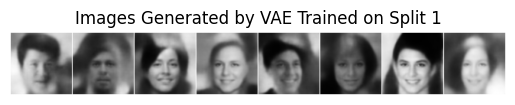

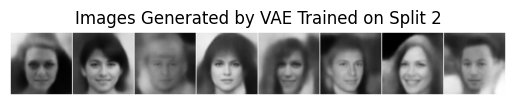

In [99]:
fixed_noise = torch.randn(8, 128, device=device)

fake_s1 = model_s1.sample(fixed_noise)
fake_s2 = model_s2.sample(fixed_noise)

print("Cosine similarities:", F.cosine_similarity(torch.flatten(fake_s1, 1), torch.flatten(fake_s2, 1)).detach().cpu())

fake_s1_cpu = fake_s1.detach().cpu()
fake_s2_cpu = fake_s2.detach().cpu()

plt.axis("off")                                                                                
plt.title("Images Generated by VAE Trained on Split 1")                                                                       
plt.imshow(np.transpose(utils.make_grid(fake_s1_cpu, padding=1, pad_value=1, normalize=True),(1,2,0)))
plt.savefig("outputs_vae1.png", dpi=400, bbox_inches="tight")
plt.show()    
plt.close()


plt.axis("off")                                                                                
plt.title("Images Generated by VAE Trained on Split 2")                                                                       
plt.imshow(np.transpose(utils.make_grid(fake_s2_cpu, padding=1, pad_value=1, normalize=True),(1,2,0)))
plt.savefig("outputs_vae2.png", dpi=400, bbox_inches="tight")
plt.show()   
plt.close()

progress: 100%|██████████| 100000/100000 [32:55<00:00, 50.61it/s]


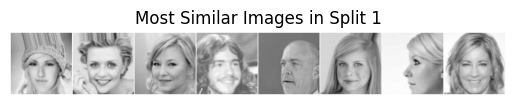

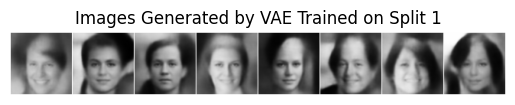

AttributeError: 'torch.return_types.max' object has no attribute 'detach'

In [57]:
split1_dataloader = torch.utils.data.DataLoader(split1_celeba, batch_size=1, num_workers=4)
cossims = []

for item in tqdm(split1_dataloader, desc="progress"):
    item = torch.flatten(item[0], 1).repeat(8, 1).to(device)
    cossim = F.cosine_similarity(item, torch.flatten(fake_s1, 1))
    cossims.append(cossim)

cossims_tensor = torch.vstack(cossims)
maxes = torch.argmax(cossims_tensor, dim=0)
maxes_val = torch.max(cossims_tensor, dim=0)

img_array = []

for idx in maxes:
    img = torch.unsqueeze(split1_celeba[idx][0], 0)
    img_array.append(img)


img_tensor = torch.vstack(img_array)
img_tensor_cpu = img_tensor.detach().cpu()

plt.axis("off")                                                                                
plt.title("Most Similar Images in Split 1")                                                                       
plt.imshow(np.transpose(utils.make_grid(img_tensor_cpu, padding=1, pad_value=1, normalize=True),(1,2,0)))
plt.savefig("mostsimilar_vae1.png", dpi=400, bbox_inches="tight")
plt.show()    
plt.close()

plt.axis("off")                                                                                
plt.title("Images Generated by VAE Trained on Split 1")                                                                       
plt.imshow(np.transpose(utils.make_grid(fake_s1_cpu, padding=1, pad_value=1, normalize=True),(1,2,0)))
plt.savefig("outputs_vae1.png", dpi=400, bbox_inches="tight")
plt.show()    
plt.close()

In [63]:
print("Cosine similarities:", maxes_val[0].detach().cpu())

Cosine similarities: tensor([0.9098, 0.8903, 0.8875, 0.8938, 0.8762, 0.8689, 0.8907, 0.8744])


progress: 100%|██████████| 100000/100000 [34:06<00:00, 48.86it/s]


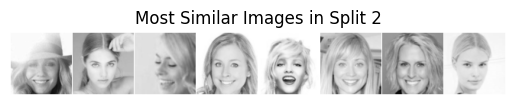

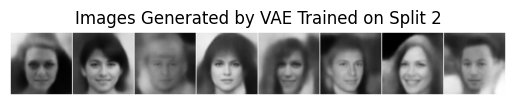

Cosine similarities: tensor([0.8763, 0.8574, 0.9217, 0.8776, 0.9034, 0.8520, 0.8533, 0.9095])


In [100]:
split2_dataloader = torch.utils.data.DataLoader(split2_celeba, batch_size=1, num_workers=4)
cossims2 = []

for item in tqdm(split2_dataloader, desc="progress"):
    item = torch.flatten(item[0], 1).repeat(8, 1).to(device)
    cossim = F.cosine_similarity(item, torch.flatten(fake_s2, 1))
    cossims2.append(cossim)

cossims_tensor2 = torch.vstack(cossims2)
maxes2 = torch.argmax(cossims_tensor2, dim=0)
maxes_val2 = torch.max(cossims_tensor2, dim=0)

img_array2 = []

for idx in maxes2:
    img = torch.unsqueeze(split2_celeba[idx][0], 0)
    img_array2.append(img)


img_tensor2 = torch.vstack(img_array2)
img_tensor_cpu2 = img_tensor2.detach().cpu()

plt.axis("off")                                                                                
plt.title("Most Similar Images in Split 2")                                                                       
plt.imshow(np.transpose(utils.make_grid(img_tensor_cpu2, padding=1, pad_value=1, normalize=True),(1,2,0)))
plt.savefig("mostsimilar_vae2.png", dpi=400, bbox_inches="tight")
plt.show()    
plt.close()

plt.axis("off")                                                                                
plt.title("Images Generated by VAE Trained on Split 2")                                                                       
plt.imshow(np.transpose(utils.make_grid(fake_s2_cpu, padding=1, pad_value=1, normalize=True),(1,2,0)))
plt.savefig("outputs_vae2.png", dpi=400, bbox_inches="tight")
plt.show()    
plt.close()
print("Cosine similarities:", maxes_val2[0].detach().cpu())

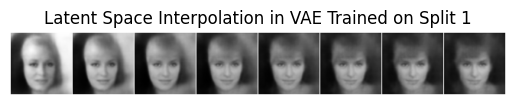

In [65]:
start = torch.randn(1, 128, device=device)
end = 3 + torch.randn(1, 128, device=device)

imgs = []

for i in range(8):
    fl = i/8
    cur = slerp(start, end, fl)
    fake_s1 = model_s1.sample(cur)

    imgs.append(fake_s1)

imgs = torch.cat(imgs).detach().cpu()

plt.axis("off")                                                                                
plt.title("Latent Space Interpolation in VAE Trained on Split 1")                                                                       
plt.imshow(np.transpose(utils.make_grid(imgs, padding=1, pad_value=1, normalize=True),(1,2,0)))
plt.savefig("latent_vae1.png", dpi=400, bbox_inches="tight")
plt.show()    
plt.close()

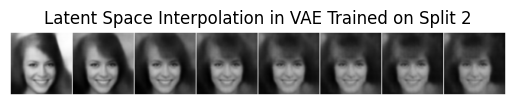

In [67]:
start = torch.randn(1, 128, device=device)
end = 3 + torch.randn(1, 128, device=device)

imgs = []

for i in range(8):
    fl = i/8
    cur = slerp(start, end, fl)
    fake_s1 = model_s1.sample(cur)

    imgs.append(fake_s1)

imgs = torch.cat(imgs).detach().cpu()

plt.axis("off")                                                                                
plt.title("Latent Space Interpolation in VAE Trained on Split 2")                                                                       
plt.imshow(np.transpose(utils.make_grid(imgs, padding=1, pad_value=1, normalize=True),(1,2,0)))
plt.savefig("latent_vae2.png", dpi=400, bbox_inches="tight")
plt.show()    
plt.close()

# GAN SECTION

Cosine similarity: tensor([0.7960, 0.7414, 0.5328, 0.6917, 0.7385, 0.7005, 0.7271, 0.6862],
       device='cuda:3', grad_fn=<SumBackward1>)


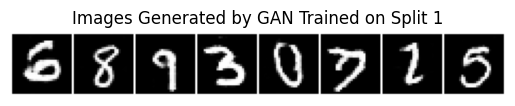

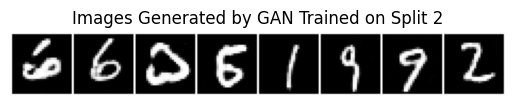

In [94]:
fixed_noise = torch.randn(8, 100, 1, 1, device=device)

fake_s1 = gan_s1(fixed_noise)
fake_s2 = gan_s2(fixed_noise)

print("Cosine similarity:", F.cosine_similarity(torch.flatten(fake_s1, 1), torch.flatten(fake_s2, 1)))

fake_s1_cpu = fake_s1.detach().cpu()
fake_s2_cpu = fake_s2.detach().cpu()

plt.axis("off")                                                                                
plt.title("Images Generated by GAN Trained on Split 1")                                                                       
plt.imshow(np.transpose(utils.make_grid(fake_s1_cpu, padding=1, pad_value=1, normalize=True),(1,2,0)))
plt.savefig("outputs_gan1.png", dpi=400, bbox_inches="tight")
plt.show()    
plt.close()


plt.axis("off")                                                                                
plt.title("Images Generated by GAN Trained on Split 2")                                                                       
plt.imshow(np.transpose(utils.make_grid(fake_s2_cpu, padding=1, pad_value=1, normalize=True),(1,2,0)))
plt.savefig("outputs_gan2.png", dpi=400, bbox_inches="tight")
plt.show()   

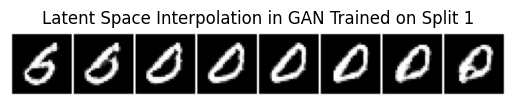

In [81]:
start = torch.randn(1, 100, 1, 1, device=device)
end = 3 + torch.randn(1, 100, 1, 1, device=device)

step = (end - start) / 7

imgs = []

for i in range(8):
    fl = i/8
    cur = slerp(start, end, fl)
    fake_s1 = gan_s1(cur)

    imgs.append(fake_s1)

imgs = torch.cat(imgs).detach().cpu()

plt.axis("off")                                                                                
plt.title("Latent Space Interpolation in GAN Trained on Split 1")                                                                       
plt.imshow(np.transpose(utils.make_grid(imgs, padding=1, pad_value=1, normalize=True),(1,2,0)))
plt.savefig("latent_gan1.png", dpi=400, bbox_inches="tight")
plt.show()    
plt.close()

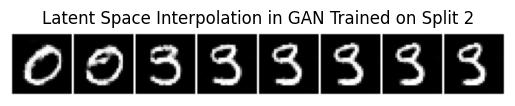

In [70]:
start = torch.randn(1, 100, 1, 1, device=device)
end = 3 + torch.randn(1, 100, 1, 1, device=device)

imgs = []

for i in range(8):
    fl = i/8
    cur = slerp(start, end, fl)
    fake_s1 = gan_s2(cur)

    imgs.append(fake_s1)

imgs = torch.cat(imgs).detach().cpu()

plt.axis("off")                                                                                
plt.title("Latent Space Interpolation in GAN Trained on Split 2")                                                                       
plt.imshow(np.transpose(utils.make_grid(imgs, padding=1, pad_value=1, normalize=True),(1,2,0)))
plt.savefig("latent_gan2.png", dpi=400, bbox_inches="tight")
plt.show()    
plt.close()

progress: 100%|██████████| 30000/30000 [01:05<00:00, 454.94it/s]


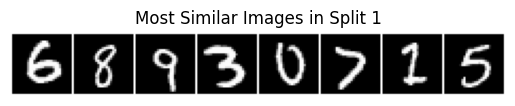

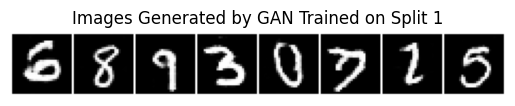

Cosine similarities: tensor([0.8813, 0.9455, 0.9555, 0.9211, 0.8741, 0.9009, 0.9560, 0.9297])


In [95]:
split1_dataloader = torch.utils.data.DataLoader(split1_mnist, batch_size=1, num_workers=4)
split2_dataloader = torch.utils.data.DataLoader(split2_mnist, batch_size=1, num_workers=4)

gancossims = []

for item in tqdm(split1_dataloader, desc="progress"):
    item = torch.flatten(item[0], 1).repeat(8, 1).to(device)
    cossim = F.cosine_similarity(item, torch.flatten(fake_s1, 1))
    gancossims.append(cossim)

gancossims_tensor = torch.vstack(gancossims)
ganmaxes = torch.argmax(gancossims_tensor, dim=0)

ganimg_array = []

for idx in ganmaxes:
    img = torch.unsqueeze(split1_mnist[idx][0], 0)
    ganimg_array.append(img)


ganimg_tensor = torch.vstack(ganimg_array)
ganimg_tensor_cpu = ganimg_tensor.detach().cpu()

plt.axis("off")                                                                                
plt.title("Most Similar Images in Split 1")                                                                       
plt.imshow(np.transpose(utils.make_grid(ganimg_tensor_cpu, padding=1, pad_value=1, normalize=True),(1,2,0)))
plt.savefig("mostsimilar_gan1.png", dpi=400, bbox_inches="tight")

plt.show()    
plt.close()

plt.axis("off")                                                                                
plt.title("Images Generated by GAN Trained on Split 1")                                                                       
plt.imshow(np.transpose(utils.make_grid(fake_s1_cpu, padding=1, pad_value=1, normalize=True),(1,2,0)))
plt.savefig("outputs_gan1.png", dpi=400, bbox_inches="tight")
plt.show()    
plt.close()

ganmaxes_vals = torch.max(gancossims_tensor, dim=0)

print("Cosine similarities:", ganmaxes_vals[0].detach().cpu())

progress: 100%|██████████| 30000/30000 [01:18<00:00, 384.24it/s]


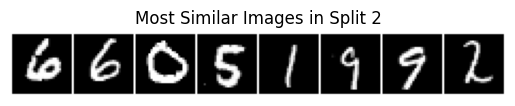

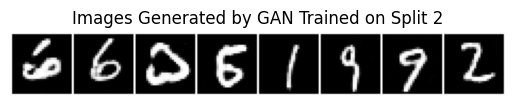

Cosine similarities: tensor([0.8949, 0.9565, 0.8514, 0.9058, 0.9846, 0.9574, 0.9684, 0.9264])


In [98]:
gancossims2 = []

for item in tqdm(split2_dataloader, desc="progress"):
    item = torch.flatten(item[0], 1).repeat(8, 1).to(device)
    cossim = F.cosine_similarity(item, torch.flatten(fake_s2, 1))
    gancossims2.append(cossim)

gancossims_tensor2 = torch.vstack(gancossims2)
ganmaxes2 = torch.argmax(gancossims_tensor2, dim=0)
ganimg_array2 = []

for idx in ganmaxes2:
    img = torch.unsqueeze(split2_mnist[idx][0], 0)
    ganimg_array2.append(img)


ganimg_tensor2 = torch.vstack(ganimg_array2)
ganimg_tensor_cpu2 = ganimg_tensor2.detach().cpu()

plt.axis("off")                                                                                
plt.title("Most Similar Images in Split 2")                                                                       
plt.imshow(np.transpose(utils.make_grid(ganimg_tensor_cpu2, padding=1, pad_value=1, normalize=True),(1,2,0)))
plt.savefig("mostsimilar_gan2.png", dpi=400, bbox_inches="tight")
plt.show()    
plt.close()

plt.axis("off")                                                                                
plt.title("Images Generated by GAN Trained on Split 2")                                                                       
plt.imshow(np.transpose(utils.make_grid(fake_s2_cpu, padding=1, pad_value=1, normalize=True),(1,2,0)))
plt.savefig("outputs_gan2.png", dpi=400, bbox_inches="tight")
plt.show()    
plt.close()

ganmaxes_vals2 = torch.max(gancossims_tensor2, dim=0)

print("Cosine similarities:", ganmaxes_vals2[0].detach().cpu())